<a href="https://colab.research.google.com/github/slz4025/knowledge_interaction_model/blob/master/A_Model_of_Knowledge_Interaction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Introduction

For the class, **Introduction to Parallel Distributed Processing [85-419]**.

Here, we present 
1. a theoretical model of how topics are interrelated in people's minds, 
2. how this model affects their learning of these topics, and 
3. the performance of different teacher strategies given this model.

#Setup

In [0]:
import numpy as np
from random import *
import math
import csv
import copy
import networkx as nx
import pandas as pd
import os
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
# hyperparameters

T = 1000                    # number of timesteps
N = 20                      # number of topics
P = 1                       # number of listeners
LEARN_RATE = 0.001          # how fast a person learns  
CONNECT_RATE = 0.05         # how fast a person connects topics
EPSILON = 0.1               # slight offset
REPEAT_INTERVAL = 10        # <visit Speaker>
"""
  NOTE: As tested, the higher this is, 
  the faster learning convergence is reached.
"""
SOFT_RADIUS = 3             # <visit Speaker>
HARD_RADIUS = 4.5           # <visit Speaker>
MIN_THRESHOLD = 0.1         # <visit Speaker>

###Skip the test cells (marked **test**), or upload `person_{0,1,2}.csv`.

#Helper functions 

In [0]:
def flatten(L): # shallow
  L = [e for l in L for e in l]
  return L

def shuffle_mapping(num):
  reindex = np.arange(num)
  np.random.shuffle(reindex)
  reindex = {i:r for i,r in enumerate(reindex)}
  invindex = {r:i for i,r in reindex.items()}
  return reindex, invindex

def reindex_val_neigh(reindex, values, neighbors):
  values_reindexed = {reindex[n]:v for n,v in values.items()}
  neighbors_reindexed = {reindex[n]:{reindex[ns]:w \
    for ns,w in neighbors[n].items()} for n in neighbors}
  return values_reindexed, neighbors_reindexed

def min_max(L):
  L_min = np.min(L)
  L_max = np.max(L)
  diff = L_max - L_min
  if diff == 0:
    L_mm = L - L_min
  else:
    L_mm = (L - L_min) / diff
  return L_mm

def sum_dict(D):
  dict_sum = 0
  for e,v in D.items():
    dict_sum += v
  return dict_sum

def conn(neighbors, topic):
  return sum_dict(neighbors[topic])

def link_average(Ln, weight = None):
  length = len(Ln)
  if weight == None:
    weight = [1 for i in range(length)]
  assert(length == len(weight) and length != 0)
  num_elem = len(Ln[0].keys())

  average = {i:{j:0 for j in range(num_elem) if j != i} \
    for i in range(num_elem)}

  for e, neighbors in enumerate(Ln):
    for i in neighbors:
      for j, v in neighbors[i].items():
        average[i][j] += v * weight[e]
        # for j not in neighbors[i], automatically do 0

  norm = sum(weight)
  average = {i: {j: float(average[i][j]) / norm \
    for j in range(num_elem) if j != i} for i in range(num_elem)}

  return average

def make_choice(available, score):
    assert(all([s >= 0 for s in score]))

    sum_score = sum(score)
    if sum_score == 0: # uniform
      probs = np.array([1 / len(score) for i in range(len(score))])
    else:
      probs = np.array([float(s) / sum_score for s in score])

    index = np.random.choice(np.arange(len(available)), p = probs)
    return available[index]

###**test**: small helper functions

In [0]:
# test shuffle_mapping
re, inv = shuffle_mapping(5)
print("re: {}".format(re))
print("inv: {}".format(inv))

# test reindex_val_neigh
test_num = 5
values = {0:0.4, 1:0.0, 2:0.99, 3:0.23, 4:0.1}
neighbors = {0:{3:2, 2:1}, 1:{2:1}, 2:{0:1, 1:1, 4:3}, 3:{0:2}, 4:{3:3}}
values_re, neighbors_re = reindex_val_neigh(re, values, neighbors)
values_inv, neighbors_inv = reindex_val_neigh(inv, values_re, neighbors_re)
print("value decoded back: ", values == values_inv)
print("neighbors decoded back: ", neighbors == neighbors_inv)

# test min_max
L = [1, -5, 0, 10, 2, -49, 3.5, 4, 100]
L_mm = min_max(L)
print(L_mm)

# test sum_dict
D = {'e': 5, 'a': 1, 'b': 2, 'd': 4, 'c': 3}
dict_sum = sum_dict(D)
print("sum_dict correct: ", dict_sum == 15)

# test conn
connectivity = conn(neighbors, 2)
print("connectivity: ", connectivity)

# test link_average
test_num = 3
D1 = {0: {1: 10, 2: 20}, 1: {0: 40, 2: 50}, 2: {0: 30, 1: 10}}
D2 = {0: {1: 1, 2: 2}, 1: {0: 4, 2: 5}, 2: {0: 3, 1: 1}}
D3 = {0: {1: 2, 2: 4}, 1: {0: 8, 2: 10}, 2: {0: 6, 1: 2}}
weight = [0.1, 1, 0.5]
Ln = [D1, D2, D3]
avg = link_average(Ln)
print("uniform avg: ", avg)
avg = link_average(Ln, weight)
print("weighted avg: ", avg)

# test make_choice
available = ['a', 'b', 'c', 'd', 'e']
score = [1, 2, 4, 4, 3]
choice = make_choice(available, score)
print("choice: ", choice)

re: {0: 2, 1: 1, 2: 4, 3: 0, 4: 3}
inv: {2: 0, 1: 1, 4: 2, 0: 3, 3: 4}
value decoded back:  True
neighbors decoded back:  True
[0.33557047 0.29530201 0.32885906 0.39597315 0.34228188 0.
 0.35234899 0.3557047  1.        ]
sum_dict correct:  True
connectivity:  5
uniform avg:  {0: {1: 4.333333333333333, 2: 8.666666666666666}, 1: {0: 17.333333333333332, 2: 21.666666666666668}, 2: {0: 13.0, 1: 4.333333333333333}}
weighted avg:  {0: {1: 1.875, 2: 3.75}, 1: {0: 7.5, 2: 9.375}, 2: {0: 5.625, 1: 1.875}}
choice:  c


In [0]:
def draw_helper(file_name, values, neighbors):
  G = nx.Graph()
  for n,v in values.items():
    red = str(hex(int(v * 255)))[2:][-2:]
    if len(red) == 0: red = "00"
    if len(red) == 1: red = "0" + red
    shade = '#' + red + '0000'
    G.add_node(n, color=shade)

  for n,neighbors in neighbors.items():
    for nn,ns in neighbors.items():
      G.add_edge(n,nn,color='black',weight=ns)

  # specify amount of optimal distance
  pos = nx.spring_layout(G, 0.75)
  for p in pos:
    pos[p][0] *= 2
    pos[p][1] *= 2

  nodes = list(G.nodes.data())
  edges = G.edges()
  node_colors = [u[1]['color'] for u in nodes]
  edge_colors = [G[u][v]['color'] for u,v in edges]
  weights = [G[u][v]['weight'] for u,v in edges]

  fig = plt.figure()
  nx.draw(G, pos, node_color=node_colors, \
    edges=edges, edge_color=edge_colors, width=weights)
  nx.draw_networkx_labels(G, pos, font_color="white")
  fig.savefig(file_name + ".png", format="PNG")
  plt.close(fig)

  return fig

In [0]:
def draw(values, neighbors):
  draw_helper("temp", values, neighbors)
  img = mpimg.imread("temp" + ".png")
  imgplot = plt.imshow(img)
  plt.show()
  print()

In [0]:
def ingest(file_name):
  all_values = {}
  all_neighbors = {}
  with open(file_name + ".csv", 'rt') as csvfile:
    reader = csv.reader(csvfile, delimiter=' ')
    for row in reader:
      topic = int(row[0])
      value = float(row[1])
      neighbors = {}
      neighbors_raw = row[2]
      if neighbors_raw != "":
        neighbors_raw = [cn.split(':') for cn in neighbors_raw.split(',')]
        for nr in neighbors_raw:
          neighbors[int(nr[0])] = int(nr[1])
      all_values[topic] = value
      all_neighbors[topic] = neighbors

  for a in all_neighbors:
    for b in all_neighbors[a]:
      assert(a in all_neighbors[b])
      assert(all_neighbors[a][b] == all_neighbors[b][a])

  return all_values, all_neighbors

In [0]:
def save(file_name, values, neighbors):
  with open(file_name + ".csv", 'wt') as csvfile:
    filewriter = csv.writer(csvfile, delimiter=' ')
    for i in range(N):
      elem0 = str(i)
      elem1 = str(values[i])
      elem2 = ','.join(["{}:{}".format(n,w) for n,w in neighbors[i].items()])
      filewriter.writerow([elem0, elem1, elem2])
  draw_helper(file_name, values, neighbors)

###**test**: `ingest`

In [0]:
values, neighbors = ingest("person_0")
print(values)
print(neighbors)

FileNotFoundError: ignored

###**test**: `save`

In [0]:
file_name = "person_save"
save(file_name, values, neighbors)
values, neighbors = ingest(file_name)
print(values)
print(neighbors)

###**test**: `draw`

In [0]:
draw(values, neighbors)

In [0]:
def diameter(neighbors, subgraph):
  """ It is critical the subgraph is actually connected.  Otherwise
      we will loop forever. """
  size = len(subgraph)
  nmat = np.zeros((size, size))
  for i,s in enumerate(subgraph):
    for j,t in enumerate(subgraph):
      if i == j: nmat[i,i] = 1
      elif t in neighbors[s]:
        nmat[i,j] = 1
  # we now keep multiplying the matrix until every entry is nonzero
  prod = nmat
  diameter = 1
  while not np.all(prod):
    prod = np.dot(prod, nmat)
    diameter += 1
  return diameter

###**test**: `diameter`

In [0]:
neighbors = {0: {5,1}, 1: {0,2}, 2: {1,3}, 3: {2,4}, 4: {3,5}, 5: {4,0}}
subgraph = [0, 1, 2, 3, 4, 5]
dia = diameter(neighbors, subgraph)
print("diameter: ", dia)

In [0]:
def subgraph_metrics(values, neighbors, subgraph):
  """
  (1) size, 
  (2) min value, (3) max value, (4) avg value, (5) std value, 
  (6) min conn, (7) max conn, (8) avg conn, (9) std conn, 
  (10) diameter.
  """
  metrics = {}
  metrics["size"] = [len(subgraph)]
  sub_values = np.array([values[s] for s in subgraph])
  metrics["min_val"] = [sub_values.min()]
  metrics["max_val"] = [sub_values.max()]
  metrics["avg_val"] = [np.mean(sub_values)]
  metrics["std_val"] = [np.std(sub_values)]
  sub_conns = np.array([conn(neighbors, s) for s in subgraph])
  metrics["min_conn"] = [sub_conns.min()]
  metrics["max_conn"] = [sub_conns.max()]
  metrics["avg_conn"] = [np.mean(sub_conns)]
  metrics["std_conn"] = [np.std(sub_conns)]
  metrics["diameter"] = [diameter(neighbors, subgraph)]

  return metrics

In [0]:
def find_subgraphs(neighbors, nodes):
  subgraphs = []
  visited = set()
  remaining = set(nodes)
  while len(remaining) > 0:
    curr = [remaining.pop()]
    subgraph = curr
    while len(curr) > 0:
      visited = visited.union(curr)
      ring = set(flatten([list(neighbors[s].keys()) for s in curr]))\
        .difference(visited)
      remaining = remaining.difference(ring)
      subgraph += ring
      curr = ring
    subgraphs.append(subgraph)
  return subgraphs

###**test**: `find_subgraphs`

In [0]:
values, neighbors = ingest("person_0")
subgraphs = find_subgraphs(neighbors, [i for i in range(N)])
draw(values, neighbors)
print(subgraphs)

#Actors and environment

##Listener

In [0]:
class Listener:

  def __init__(self, values, neighbors, learn_rate, connect_rate):
    self.values = values           # level of knowledge in topic
    self.neighbors = neighbors     # other topic and number of links
    self.prev_topic = None         # both speakers, listeners use this
    self.learn_rate = learn_rate
    self.connect_rate = connect_rate
    self.journal = []
    # matrix that holds incremental updates
    self.learn_connect = np.zeros((N, N))
    for i in self.neighbors:
      for j in self.neighbors[i]:
        self.learn_connect[i, j] = float(self.neighbors[i][j])

  def listen(self, topic, other_value):
    # compute connectivity of topic, one-away with strength (NOTE: no exp)
    connectivity = conn(self.neighbors, topic)

    # update value of topic
    addition = self.learn_rate * other_value * \
               (connectivity + 1) * \
               (self.values[topic] + EPSILON)
    addition = min(1.0 - self.values[topic], addition)
    self.values[topic] += addition

    # record our update in our journal
    self.journal.append((topic, addition))

    # update connectivity of topic
    if self.prev_topic != None:
      if self.prev_topic != topic:
        self.learn_connect[topic,self.prev_topic] += self.connect_rate
        self.learn_connect[self.prev_topic, topic] += self.connect_rate
        assert(self.learn_connect[topic,self.prev_topic] \
          == self.learn_connect[self.prev_topic, topic])
        updated_conn = math.floor(self.learn_connect[topic,self.prev_topic])
        self.neighbors[topic][self.prev_topic] = updated_conn
        self.neighbors[self.prev_topic][topic] = updated_conn

    self.prev_topic = topic
    return addition

  def draw(self):
    draw(self.values, self.neighbors)

###**test**: `Listener` instantiate

In [0]:
values, neighbors = ingest("person_0")
listener = Listener(values, neighbors, LEARN_RATE, CONNECT_RATE)
listener.draw()

###**test**: `Listener` step

In [0]:
topic = 10
other_value = 0.1
addition = listener.listen(topic, other_value)
listener.draw()
print("addition for topic {} with value {}: {}"\
  .format(topic, other_value, addition))

##Speaker

In [0]:
class Speaker:

  def __init__(self, values, neighbors, target, args):
    self.values = values
    self.neighbors = neighbors
    self.target = target
    self.speak_count = 0
    self.prev_topic = None
    self.args = args
    self.journal = []
    self.classroom = None
    self.strategy = None
    self.acceptable_topics = None
    assert(self.values[target] > 0) # so we can actually teach

    """
      strategy: fixed, inspired, feedback
        how we choose a topic
      repeat: 0, 1
        whether we repeat the target topic
      constrained: none, bubble, apriori
        set of topics the spoken one is allowed to be
      *soft_radius: <int> [if strategy == inspired]
        iterations of probabilistic traversal from topic
      *help_min: 0, 1 [if strategy == feedback]
        whether we focus on minimum bracket students
      *repeat_interval: <int> [if repeat == 1]
        interval between repeats
      *hard_radius: <int> [if constrained == bubble/apriori]
        distance from target
      *min_threshold: <float> [if help_min == 1]
        for inverse function when doing help_min
    """
    if "strategy" not in self.args:
      print("ERROR: no `strategy` argument")
      return
    if "repeat" not in self.args:
      print("ERROR: no `repeat` argument")
      return
    if "constrained" not in self.args:
      print("ERROR: no `constrained` argument")
      return
    if self.args["strategy"] not in ["fixed", "inspired", "feedback"]:
      print("ERROR: `strategy` must be in ['fixed', 'inspired', 'feedback']")
      return
    if self.args["repeat"] not in [0, 1]:
      print("ERROR: `repeat` must be in [0, 1]")
      return
    if self.args["constrained"] not in ["none", "bubble", "apriori"]:
      print("ERROR: `constrained` must be in ['none', 'bubble', 'apriori']")
      return
    if self.args["strategy"] == "inspired":
      if "soft_radius" not in self.args:
        print("ERROR: no `soft_radius` argument when `strategy` == 'inspired'") 
        return
    if self.args["strategy"] == "feedback":
      if "help_min" not in self.args:
        print("ERROR: no `help_min` argument when `strategy` == 'feedback'")
        return
      if self.args["help_min"] == 1:
        if "min_threshold" not in self.args:
          print("ERROR: no `min_threshold` argument when `help_min` == 1")
          return
    if self.args["repeat"] == 1:
      if "repeat_interval" not in self.args:
        print("ERROR: no `repeat_interval` argument when `repeat` == 1")
        return
    if self.args["constrained"] == "bubble":
      if "hard_radius" not in self.args:
        print("ERROR: no `hard_radius` argument when `constrained` == bubble")
        return
    if self.args["constrained"] == "apriori":
      if "hard_radius" not in self.args:
        print("ERROR: no `hard_radius` argument when `constrained` == apriori")
        return

  def set_classroom(self, classroom): # run before speak
    self.classroom = classroom

  def init_speak(self):
    if self.args["strategy"] == "fixed":
      self.strategy = self.fixed
    elif self.args["strategy"] == "inspired":
      self.strategy = self.inspired
    elif self.args["strategy"] == "feedback":
      self.strategy = self.feedback
    assert(self.args["strategy"] in ["fixed", "inspired", "feedback"])
    
    self.acceptable_topics = [i for i in range(N)] # default to all

    # limit to those that are close to the target in speaker
    if self.args["constrained"] == "bubble":
      hard_radius = self.args["hard_radius"]
      self.acceptable_topics = self.hard_spider(self.target, hard_radius, \
        self.neighbors)

    if self.args["constrained"] == "apriori":
      hard_radius = self.args["hard_radius"]
      student_neighbors = [s.neighbors for s in self.classroom.students]
      avg_listener_neighbors = link_average(student_neighbors)
      self.acceptable_topics = self.hard_spider(self.target, hard_radius, \
        avg_listener_neighbors)
    print("acceptable_topics: ", self.acceptable_topics)

  # The distance between two nodes given their connectivity strength.
  # This formula is also based on the expected number of steps before being
  #   able to jump from one node to another via soft_spider.
  def exp_dist(self, connectivity_strength):
    return 1.0 / (1.0 - math.pow(0.5, connectivity_strength))

  def distance(self, topic, neighbors):
    dist = [None for i in range(N)]
    dist[topic] = 0
    visited = set([topic])
    prev_pass = []
    curr_pass = [topic]
    next_pass = []
    while prev_pass != curr_pass:
        next_pass = []
        for c in curr_pass:
          for n, v in neighbors[c].items():
            if v == 0: continue # bad edge
            if not n in visited:
              next_pass.append(n)
            this_dist = self.exp_dist(v) # if v = 0, dist is inf
            tot_dist = dist[c] + this_dist
            if dist[n] == None:
              dist[n] = tot_dist
            else:
              dist[n] = min(dist[n], tot_dist)
        visited = visited.union(set(next_pass))
        prev_pass = curr_pass
        curr_pass = next_pass
        print()
    return dist

  # assume neighbors has all topics with given id
  def hard_spider(self, topic, radius, neighbors): # by distance
    dist = self.distance(topic, neighbors)
    acceptable = [i for i,d in enumerate(dist) if d != None and d <= radius]
    return acceptable

  def soft_spider(self, topic, radius):
    current_pass = [topic]
    visited = []
    while radius > 0:
      next_pass = []
      for c in current_pass:
        visited.append(c)
        for n,sn in self.neighbors[c].items():
          pass_thres = math.pow(0.5, sn)
          if random() > pass_thres:
            next_pass.append(n)
      current_pass = next_pass
      radius -= 1

    return list(set(visited))
 
  def fixed(self):
    return self.target

  def inspired(self):
    soft_radius = self.args["soft_radius"]

    potential = self.soft_spider(self.prev_topic, soft_radius)

    # constrain to acceptable topics
    potential = [p for p in potential if p in self.acceptable_topics]
    
    # can always go back to prev topic, which we came from
    assert(len(potential) != 0)

    # relative connectivity among potential
    connectivity = min_max([conn(self.neighbors, p) \
      for p in potential])
      
    # simple score of which node to go to based on connectivity and value
    scores = [self.values[potential[i]] + connectivity[i] \
      for i in range(len(potential))]

    topic = make_choice(potential, scores)

    return topic

  def inverse_weight(self): # TODO: may make more elegant
    inverse_weight_max = 1 / self.args["min_threshold"]
    weight = []

    for i,s in enumerate(self.classroom.students):
      proficiency = s.values[self.target]
      weight.append(min(inverse_weight_max, 1 / proficiency))

    return weight

  # generally, choose topics that on average are highly connected to target
  def feedback(self): 
    student_neighbors = [s.neighbors for s in self.classroom.students]
    # choose topics struggling students can relate best to
    if self.args["help_min"]:
      weight = self.inverse_weight()
      avg_neighbors = link_average(student_neighbors, weight)
    else: # uniform weighting
      avg_neighbors = link_average(student_neighbors)

    # score is based on inverse distance
    # can also be exponential
    # TODO: may also consider using a soft spider or hard spider
    defined = {n:v for n,v in avg_neighbors[self.target].items() if v != 0}
    available = list(defined.keys())
    scores = min_max([1 / self.exp_dist(v) for v in defined.values()])
    
    topic = make_choice(available, scores)

    return topic

  def speak(self):
    if self.prev_topic == None:
      topic = target
    else:
      if self.args["repeat"]:
        repeat_interval = self.args["repeat_interval"]
        if self.speak_count % repeat_interval == 0:
          topic = self.target
        else:
          topic = self.strategy()
      else:
        topic = self.strategy()

    topic_value = self.values[topic]
    self.journal.append((topic, topic_value))
    self.prev_topic = topic
    self.speak_count += 1

    return topic, topic_value

  def draw(self):
    draw(self.values, self.neighbors)

###**test**: `Speaker` instantiate

In [0]:
"""
  NOTE: In order to test the feedback strategy or the apriori constraint,
  need to have a classroom.
"""

target = 10
values, neighbors = ingest("person_0")
args = {"strategy": "inspired", "repeat": 0, "constrained": "none", \
        "repeat_interval": REPEAT_INTERVAL, \
        "soft_radius": SOFT_RADIUS, "hard_radius": HARD_RADIUS, \
        "help_min": 0, "min_threshold": MIN_THRESHOLD}
speaker = Speaker(values, neighbors, target, args)
speaker.init_speak()
values, neighbors = ingest("person_1")
listener = Listener(values, neighbors, LEARN_RATE, CONNECT_RATE)

print("Speaker")
speaker.draw()
print("Listener")
listener.draw()

###**test**: `Speaker` step

In [0]:
topic, topic_value = speaker.speak()
addition = listener.listen(topic, topic_value)
print("speaker\ttopic: {}\ttopic_value: {}".format(topic, topic_value))
listener.draw()
print("addition for topic {} with value {}: {}"\
  .format(topic, other_value, addition))

##Classroom

One teacher, many student model of discussion.


In [0]:
class Classroom:
  
  def __init__(self, teacher, students):
    self.teacher = teacher
    self.students = students
    self.teacher.set_classroom(self)
    self.teacher.init_speak()
    self.topic = None
    self.value = None
    self.additions = []
  
  def step(self):
    topic, value = self.teacher.speak()
    self.topic = topic
    self.value = value
    self.additions = []
    for i,s in enumerate(self.students):
      add = s.listen(topic, value)
      self.additions.append(add)

  def output(self):
    print("Teacher")
    self.teacher.draw()
    for i,s in enumerate(self.students):
      print("Student {}".format(i))
      s.draw()

  def export(self, file_name):
    data = {}
    # topics
    topics_visited = [t for t,a in self.teacher.journal]
    data["topic"] = topics_visited
    # teacher
    teacher_ID = str(0)
    elems = [a for t,a in self.teacher.journal]
    data["teacher"] = elems
    # students are numbered entries
    for i,s in enumerate(self.students):
      ID = str(i + 1)
      assert([t for t,a in s.journal] == topics_visited)
      elems = [a for t,a in s.journal]
      data["student_" + str(i)] = elems
    df = pd.DataFrame(data)
    df = df.reset_index()
    df.to_csv(file_name + ".csv")


###**test**: `Classroom` instantiate

In [0]:
values0, neighbors0 = ingest("person_0")
values1, neighbors1 = ingest("person_1")
values2, neighbors2 = ingest("person_2")

target = 10
args = {"strategy": "feedback", "repeat": 1, "constrained": "none", \
        "repeat_interval": REPEAT_INTERVAL, \
        "soft_radius": SOFT_RADIUS, "hard_radius": HARD_RADIUS, \
        "help_min": 0, "min_threshold": MIN_THRESHOLD}
teacher = Speaker(values0, neighbors0, target, args)

student1 = Listener(values1, neighbors1, LEARN_RATE, CONNECT_RATE)
student2 = Listener(values2, neighbors2, LEARN_RATE, CONNECT_RATE)
students = [student1, student2]

classroom = Classroom(teacher, students)
classroom.output()

###**test**: `Classroom` step

In [0]:
classroom.step()
print("topic: {}\tvalue: {}" \
  .format(classroom.topic, classroom.value))
print(classroom.additions)
classroom.output()

###**test**: `Classroom` report

In [0]:
classroom.output()
classroom.export("classroom")

#Creating dataset

In [0]:
"""
  knowledge is mean of Gaussian that produces values [0,1]
  generalism is power assigned to connections vs values, lower is more [0,1]
  iterations, number of times to run process [1,inf)
"""

def instantiate(knowledge, generalism, iterations):
  value_mean = knowledge 
  value_std = 0.25
  topic_values = np.clip(np.random.normal(value_mean, value_std, N), 0.0, 1.0)
  values = {i:topic_values[i] for i in range(N)}
 
  # generate connections
  neighbors = {i:{} for i in range(N)}

  # prevent following routine to affect topics asymmetrically
  reindex, invindex = shuffle_mapping(N)
  values_reindexed, neighbors_reindexed = \
    reindex_val_neigh(reindex, values, neighbors)
    
  # create graph based on value and connectivity
  for it in range(iterations):
  # get the connectivity of nodes at this layer
    neighbors_mm = min_max([conn(neighbors_reindexed, i) \
      for i in range(N)])
    # create new connections based on value and connectivity 
    for i in range(N):
      for j in range(i+1, N):
        prob = \
          (values_reindexed[i] * values_reindexed[j]) * \
          math.pow(neighbors_mm[i] * neighbors_mm[j] + EPSILON, generalism)
        if random() < prob:
          if j not in neighbors_reindexed[i]:
            assert(i not in neighbors_reindexed[j])
            neighbors_reindexed[i][j] = 1
            neighbors_reindexed[j][i] = 1
          else:
            assert(i in neighbors_reindexed[j])
            neighbors_reindexed[i][j] += 1
            neighbors_reindexed[j][i] += 1

  # convert back to topic-index
  values, neighbors = reindex_val_neigh(\
    invindex, values_reindexed, neighbors_reindexed)

  return values, neighbors

###Either run the code below to get a new dataset, or simply upload `data.zip`.

In [0]:
make_data = False #@param {type: 'boolean'}

In [0]:
if make_data:
  !mkdir data
  sample_size = 100
  for inc in range(0, 16):
    for i in range(sample_size):
      values, neighbors = instantiate(0.25, (inc + 5) * 0.05, 3)
      file_name = "data/person_{}".format(inc * sample_size + i)
      save(file_name, values, neighbors)
  !zip data.zip data/*

#Dataset analysis

We choose a set of specialist teachers and generalist teachers.

In [0]:
!unzip data.zip

In [0]:
folder = "data/"
prefix = "person_"
people = {}
P = 1600
for i in range(P):
  file_name = folder + prefix + str(i)
  print(file_name)
  values, neighbors = ingest(file_name)
  people[i] = (values, neighbors)

In [0]:
rows = []
nodes = [n for n in range(N)]
for i, person in people.items():
  values, neighbors = person
  subgraphs = find_subgraphs(neighbors, nodes)
  for s in subgraphs:
    sub_row = subgraph_metrics(values, neighbors, s)
    sub_row["person"] = i
    for n in s:
      node_row = sub_row
      node_row["topic"] = [n] 
      node_row["value"] = [values[n]]
      node_row["conn"] = [conn(neighbors, n)]
      rows.append(pd.DataFrame.from_dict(node_row))
frame = pd.concat(rows)

In [0]:
value_bins = [i * 0.05 for i in range(21)]
frame["value_bin"] = pd.cut(frame["value"], value_bins)
frame["avg_val_bin"] = pd.cut(frame["avg_val"], value_bins)

##Specialist analysis

`value_bin = [0.75, 1)`

`size = [2,4]`

In [0]:
# specialist analysis

value_threshold = 15 # 0.75
size_min_threshold = 2
size_max_threshold = 4

specialist = frame[frame["size"] >= size_min_threshold]
specialist = specialist[specialist["size"] <= size_max_threshold]
specialist = specialist[specialist["value"] >= value_threshold * 0.05]
specialist = specialist.sort_values(by=["value_bin","size"])
specialist = specialist.reset_index()

ss = specialist.groupby(["value_bin", "size"])
ss = ss["topic"].count()
ss = ss.unstack(level="size")
plt.figure(num=None, figsize=(1, 6), dpi=80, facecolor='w', edgecolor='k')
heatmap = plt.pcolor(ss, cmap=plt.cm.Blues)
plt.colorbar(heatmap)
plt.xticks(np.arange(0.5, len(ss.columns)), ss.columns)
plt.yticks(np.arange(0.0, len(ss.index)), \
  [i/20 for i in range(len(ss.index))])
plt.show()

specialist.to_csv("specialist.csv")

##Generalist `avg_val` analysis

In [0]:
size_threshold = 1 # group size is at least 2
generalist1 = frame[frame["size"] > size_threshold]
generalist1 = generalist1.groupby(["value_bin", "avg_val_bin"])
gs1 = generalist1["topic"].count()
gs1 = gs1.unstack(level="avg_val_bin")
gs1 = gs1.loc[:, :] # row : value_bin, col : avg_val_bin
plt.figure(num=None, figsize=(9, 6), dpi=80, facecolor='w', edgecolor='k')
heatmap = plt.pcolor(gs1, cmap=plt.cm.Blues)
plt.colorbar(heatmap)
plt.xticks(np.arange(0.0, len(gs1.columns), 1), \
  [i/20 for i in range(20)])
plt.yticks(np.arange(0.0, len(gs1.index), 1), \
  [i/20 for i in range(20)])
plt.show()

##Generalist analysis

`value >= 0.25`

`size >= 5`

`avg_val_bin >= 0.3`

In [0]:
# generalist analysis
avg_val_threshold = 0.3
value_threshold = 5 # 0.25
size_threshold = 5

# generalist: value_bin [0.25, 1), size [5, inf), avg_val [0.3, 1)
generalist = frame[frame["avg_val"] > avg_val_threshold]
generalist = generalist[generalist["size"] >= size_threshold]
generalist = generalist[generalist["value"] >= value_threshold * 0.05]
generalist = generalist.sample(frac=1)
generalist = generalist.sort_values(by=["value_bin","size"])
generalist = generalist.reset_index()
generalist["overflow"] = 0
max_cell_threshold = 5
counter = 0
prev_vb = None 
prev_size = None
for i, row in generalist.iterrows():
  if row["value_bin"] == prev_vb and row["size"] == prev_size:
    counter += 1
  else:
    counter = 1
    prev_vb = row["value_bin"]
    prev_size = row["size"]
    continue
  if counter > max_cell_threshold:
    generalist.loc[i, "overflow"] = 1
generalist = generalist[generalist["overflow"] == 0]
generalist = generalist.reset_index()

gs2 = generalist.groupby(["value_bin", "size"])
gs2 = gs2["topic"].count()
gs2 = gs2.unstack(level="size")
plt.figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
heatmap = plt.pcolor(gs2, cmap=plt.cm.Blues)
plt.colorbar(heatmap)
plt.xticks(np.arange(0.5, len(gs2.columns), 1), gs2.columns)
plt.yticks(np.arange(0.0, len(gs2.index), 1), \
  [i/20 for i in range(20)])
plt.show()

generalist.to_csv("generalist.csv")

#Experimental runs

###Choose analysis and teacher set
Please upload `specialist_time.csv` and `generalist_time.csv` for "time_convergence".

Please upload `specialist.csv` and `generalist.csv` for "heatmap".

In [0]:
analysis = "heat_map" #@param ["time_convergence", "heat_map"]

In [0]:
usecols = [i for i in range(17)]

dtype = {"size":np.int32,\
  "min_val":np.float64,"max_val":np.float64,\
  "avg_val":np.float64,"std_val":np.float64,\
  "min_conn":np.float64,"max_conn":np.float64,\
  "avg_conn":np.float64,"std_conn":np.float64,\
  "diameter":np.int32,\
  "person":np.int32,"topic":np.int32,\
  "value":np.float64,"conn":np.int32,\
  "value_bin":str,"avg_val_bin":str}

if analysis == "time_convergence":
  specialist = pd.read_csv("specialist_time.csv",\
    usecols=usecols, index_col=0, nrows=14, dtype=dtype)
  generalist = pd.read_csv("generalist_time.csv",
    usecols=usecols, index_col=0, nrows=16, dtype=dtype)
else: 
  assert(analysis == "heat_map")
  specialist = pd.read_csv("specialist.csv")
  generalist = pd.read_csv("generalist.csv")

In [0]:
value_bins = [i * 0.2 for i in range(7)]
frame["value_band"] = pd.cut(frame["value"], value_bins, \
  right=False, include_lowest=True)
frame["avg_val_band"] = pd.cut(frame["avg_val"], value_bins, \
  right=False, include_lowest=True)
students_by_topic = {}

for i in range(N):
  temp = frame[frame["topic"] == i]
  students_by_topic[i] = temp.reset_index()

In [0]:
# teaching methods

strategies = ["fixed", "inspired", "inspired_repeat", \
              "feedback_repeat", "feedback_inverse_repeat"]
args_fixed = {"strategy":"fixed", \
              "repeat":0, \
              "constrained":"none"}
args_inspired = {"strategy":"inspired", \
                 "repeat":0, \
                 "constrained":"none",\
                 "soft_radius": SOFT_RADIUS}
args_inspired_repeat = {"strategy":"inspired", \
                        "repeat":1, \
                        "constrained":"none", \
                        "repeat_interval":REPEAT_INTERVAL,\
                        "soft_radius": SOFT_RADIUS}
args_feedback_repeat = {"strategy":"feedback", \
                 "repeat":1, \
                 "constrained":"none", \
                 "repeat_interval":REPEAT_INTERVAL,\
                 "help_min":0}
args_feedback_inverse_repeat = {"strategy":"feedback", \
                         "repeat":0, \
                         "constrained":"none",\
                         "repeat_interval":REPEAT_INTERVAL,\
                         "help_min":1, \
                         "min_threshold":MIN_THRESHOLD}

In [0]:
def trajectories(teacher_inp, strategy):
  person, topic, vn = teacher_inp

  if strategy == "fixed":
    args = args_fixed
  elif strategy == "inspired":
    args = args_inspired
  elif strategy == "inspired_repeat":
    args = args_inspired_repeat
  elif strategy == "feedback_repeat":
    args = args_feedback_repeat
  elif strategy == "feedback_inverse_repeat":
    args = args_feedback_inverse_repeat
  else:
    print("bad strategy: '{}'".format(strategy))
    return

  values, neighbors = vn
  target = topic
  values = copy.deepcopy(values)
  neighbors = copy.deepcopy(neighbors)
  teacher = Speaker(values, neighbors, target, args)

  students = []
  for i,p in people.items():
    values, neighbors = p
    values = copy.deepcopy(values)
    neighbors = copy.deepcopy(neighbors)
    student = Listener(values, neighbors, LEARN_RATE, CONNECT_RATE)
    students.append(student)

  classroom = Classroom(teacher, students)
  for i in range(T):
    if i % (T // 10) == 0:
      print("Step ", i)
    classroom.step()

  classroom.export("classroom")
  classroom_trajs = pd.read_csv("classroom.csv")
  topics = classroom_trajs["topic"]
  teacher_traj = classroom_trajs["teacher"]
  student_trajs = []
  for i in people.keys():
    student_trajs.append(classroom_trajs["student_" + str(i)])

  return topics, teacher_traj, student_trajs

##Per-teacher time convergence analysis

In [0]:
# plot a specific time convergence graph

up_to = T

def plot_time_convergence_helper(headline, all_trajs):
  min_traj = np.amin(all_trajs, axis=0)
  max_traj = np.amax(all_trajs, axis=0)
  mean_traj = np.mean(all_trajs, axis=0)
  std_traj = np.std(all_trajs, axis=0)
  under_traj = np.clip(mean_traj - std_traj, 0.0, 1.0)
  over_traj = np.clip(mean_traj + std_traj, 0.0, 1.0)

  fig = plt.figure()
  plt.plot(min_traj[:up_to], linewidth=1, color="red")
  plt.plot(max_traj[:up_to], linewidth=1, color="green")
  plt.plot(mean_traj[:up_to], linewidth=2, color="blue")
  plt.fill_between([t for t in range(up_to)], \
    under_traj[:up_to], over_traj[:up_to], color="blue", alpha=.1)
  print(headline)
  plt.savefig(headline + ".png")
  plt.show()

def plot_time_convergence(headline, all_trajs, time_topics, target_topic):
  # all time-points
  plot_time_convergence_helper(headline, all_trajs)

  # only target time-points
  all_trajs_target = np.zeros(all_trajs.shape)
  time_mimic = 0
  for i in range(time_topics.shape[0]):
    if time_topics[i] == target_topic:
      time_mimic = i
    all_trajs_target[:,i] = all_trajs[:,time_mimic]
  plot_time_convergence_helper(headline + "_target", all_trajs_target)

In [0]:
def generate_time_convergence(teacher, strategy, img_file):

   person, topic, vn = teacher
   
  instance = img_file + \
    "/strategy_{}_person_{}_topic_{}_".format(strategy,person,topic)
    
   print("Teacher: {}\tTopic: {}\tStrategy: {}".format(person, topic, strategy))
   topics, teacher_trajs, students_trajs = trajectories(teacher, strategy)

  value_band_ = list(students_by_topic[topic]["value_band"].unique())
  size_ = sorted(list(students_by_topic[topic]["size"].unique()))
  avg_val_band_ = list(students_by_topic[topic]["avg_val_band"].unique())

  cells = {i:{j:{k:[] \
    for k in avg_val_band_} for j in size_} for i in value_band_}
  for i, row in students_by_topic[topic].iterrows():
    assert(row["topic"] == topic)
    person = row["person"]
    value_band = row["value_band"]
    size_band = row["size"]
    avg_val_band = row["avg_val_band"]
    cells[value_band][size_band][avg_val_band].append(student_trajs[person])

  for i in value_band_:
    all_trajs = [] # row : person / col : time
    for j in size_:
      for k in avg_val_band_:  
        all_trajs += cells[i][j][k]
    all_trajs = np.array(all_trajs)
    headline = "value_{}".format(i)
    headline = instance + headline
    plot_time_convergence(headline, all_trajs, topics, topic)

  for i in size_:
    all_trajs = [] # row : person / col : time
    for j in value_band_:
      for k in avg_val_band_:  
        all_trajs += cells[j][i][k]
    all_trajs = np.array(all_trajs)
    headline = "size_{}".format(i)
    headline = instance + headline
    plot_time_convergence(headline, all_trajs, topics, topic)

  for i in avg_val_band_:
    all_trajs = [] # row : person / col : time
    for j in value_band_:
      for k in size_:  
        all_trajs += cells[j][k][i]
    all_trajs = np.array(all_trajs)
    headline = "avg_val_{}".format(i)
    headline = instance + headline
    plot_time_convergence(headline, all_trajs, topics, topic)

  all_trajs = [] # row : person / col : time
  for i in value_band_:
    for j in size_:
      for k in avg_val_band_:  
        all_trajs += cells[i][j][k]
  all_trajs = np.array(all_trajs)
  headline = instance
  plot_time_convergence(headline, all_trajs, topics, topic)


In [0]:
# specialists

if analysis == "time_convergence":
  specialist_teachers = []
  for i, row in specialist.iterrows():
    topic = row["topic"]
    person = row["person"]
    value, neighbors = people[person]
    specialist_teachers.append((person, topic, (value, neighbors)))

  img_file = "specialist_imgs"
  !mkdir $img_file
  for s in strategies:
    for st in specialist_teachers:
      generate_time_convergence(st, s, img_file)
  !zip -r $img_file".zip" $img_file

In [0]:
# generalists

if analysis == "time_convergence":
  generalist_teachers = []
  for i, row in generalist.iterrows():
    topic = row["topic"]
    person = row["person"]
    value, neighbors = people[person]
    generalist_teachers.append((person, topic, (value, neighbors)))

  img_file = "generalist_imgs"
  !mkdir $img_file
  for s in strategies:
    for st in generalist_teachers:
      generate_time_convergence(st, s, img_file)
  !zip -r $img_file".zip" $img_file

##Teacher comparison via heatmap


In [0]:
# specialist

if analysis == "heat_map":
  specialist_groups = specialist.groupby(["value_bin", "size"])

  for s in strategies:
    print("Strategy: ", s)
    strat_df = pd.DataFrame({}, index = specialist["value_bin"].unique(), \
      columns = specialist["size"].unique())
    
    for label, group in specialist_groups:
      value_bin_label = label[0]
      size_label = label[1]

      teachers = []
      for i, row in group.iterrows():
        topic = row["topic"]
        person = row["person"]
        value, neighbors = people[person]
        teachers.append((person, topic, (value, neighbors)))

      cum_add = []
      for st in teachers:
        topics, teacher_trajs, students_trajs = trajectories(st, s)
        cum_add += [np.sum(np.array(stt)) for stt in students_trajs]
      avg_learn = np.mean(np.array(cum_add))
      strat_df.loc[value_bin_label, size_label] = avg_learn

    strat_df.to_csv("specialist_{}.csv".format(s))

In [0]:
# generalist

if analysis == "heat_map":
  generalist_groups = generalist.groupby(["value_bin", "size"])

  for s in strategies:
    print("Strategy: ", s)
    strat_df = pd.DataFrame({}, index = generalist["value_bin"].unique(), \
      columns = generalist["size"].unique())
    
    for label, group in generalist_groups:
      value_bin_label = label[0]
      size_label = label[1]

      teachers = []
      for i, row in group.iterrows():
        topic = row["topic"]
        person = row["person"]
        value, neighbors = people[person]
        teachers.append((person, topic, (value, neighbors)))

      cum_add = []
      for st in teachers:
        topics, teacher_trajs, students_trajs = trajectories(st, s)
        cum_add += [np.sum(np.array(stt)) for stt in students_trajs]
      avg_learn = np.mean(np.array(cum_add))
      strat_df.loc[value_bin_label, size_label] = avg_learn

    strat_df.to_csv("generalist_{}.csv".format(s))

In [0]:
# standard comparison of value across plots
low_extent = 0
high_extent = 1
specialist_folder = "specialist_heat_map/"
generalist_folder = "generalist_heat_map/"

In [0]:
!mkdir $specialist_folder

def show_specialist(specialist_df, name):
  print(name)
  plt.figure(num=None, figsize=(3, 4), dpi=80, facecolor='w', edgecolor='k')
  heatmap = plt.pcolor(specialist_df, cmap=plt.cm.Blues, \
    vmin=low_extent, vmax=high_extent)
  plt.colorbar(heatmap)
  plt.xticks(np.arange(0.5, len(specialist_df.columns), 1), \
    specialist_df.columns) # size
  plt.yticks(np.arange(0.5, len(specialist_df.index), 1), \
    specialist_df.index) # value_bin
  plt.savefig(specialist_folder + name + ".png")
  plt.show()

In [0]:
!mkdir $generalist_folder

def show_generalist(generalist_df, name):
  print(name)
  plt.figure(num=None, figsize=(8, 4), dpi=80, facecolor='w', edgecolor='k')
  heatmap = plt.pcolor(generalist_df, cmap=plt.cm.Blues, \
    vmin=low_extent, vmax=high_extent)
  plt.colorbar(heatmap)
  plt.xticks(np.arange(0.5, len(generalist_df.columns), 1), \
    generalist_df.columns) # size
  plt.yticks(np.arange(0.5, len(generalist_df.index), 1), \
    generalist_df.index) # value_bin
  plt.savefig(generalist_folder + name + ".png")
  plt.show()

specialist_fixed


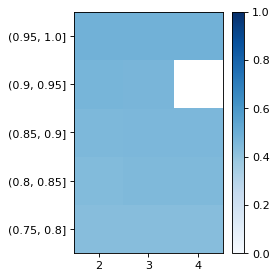

specialist_inspired


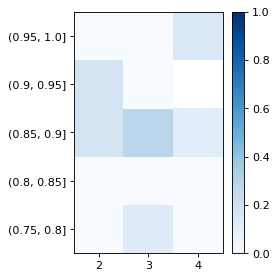

specialist_inspired_repeat


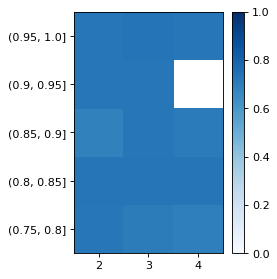

specialist_feedback_repeat


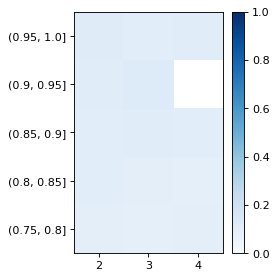

In [0]:
specialist_fixed = pd.read_csv(\
  "specialist_fixed.csv", index_col=0)
specialist_inspired = pd.read_csv(\
  "specialist_inspired.csv", index_col=0)
specialist_inspired_repeat = pd.read_csv(\
  "specialist_inspired_repeat.csv", index_col=0)
specialist_feedback_repeat = pd.read_csv(\
  "specialist_feedback_repeat.csv", index_col=0)

show_specialist(specialist_fixed, "specialist_fixed")
show_specialist(specialist_inspired, "specialist_inspired")
show_specialist(specialist_inspired_repeat, "specialist_inspired_repeat")
show_specialist(specialist_feedback_repeat, "specialist_feedback_repeat")

!zip -r $specialist_folder".zip" $specialist_folder

generalist_fixed


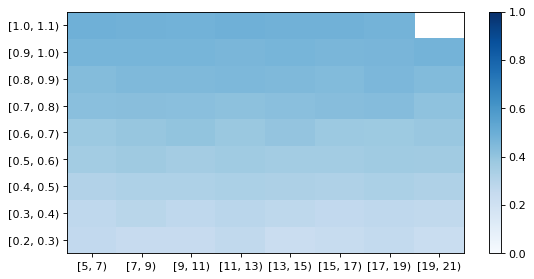

generalist_inspired


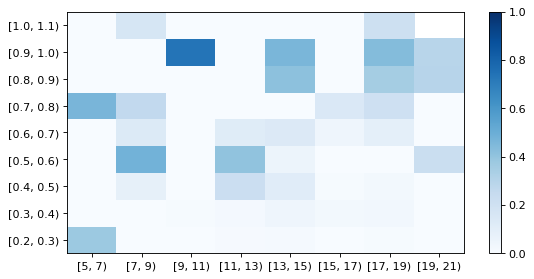

generalist_inspired_repeat


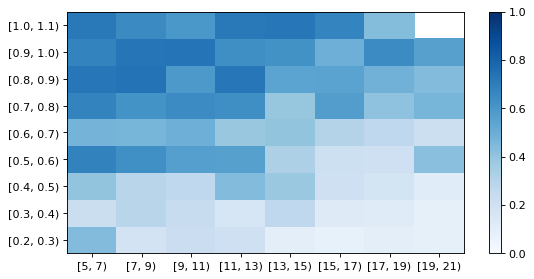

generalist_feedback_repeat


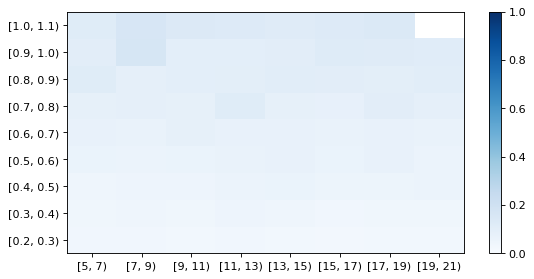

  adding: generalist_heat_map/ (stored 0%)
  adding: generalist_heat_map/generalist_inspired_repeat.png (deflated 16%)
  adding: generalist_heat_map/generalist_inspired.png (deflated 15%)
  adding: generalist_heat_map/generalist_fixed.png (deflated 15%)
  adding: generalist_heat_map/generalist_feedback_repeat.png (deflated 16%)


In [0]:
generalist_fixed = pd.read_csv(\
  "generalist_fixed.csv", index_col=0)
generalist_inspired = pd.read_csv(\
  "generalist_inspired.csv", index_col=0)
generalist_inspired_repeat = pd.read_csv(\
  "generalist_inspired_repeat.csv", index_col=0)
generalist_feedback_repeat = pd.read_csv(\
  "generalist_feedback_repeat.csv", index_col=0)

show_generalist(generalist_fixed, "generalist_fixed")
show_generalist(generalist_inspired, "generalist_inspired")
show_generalist(generalist_inspired_repeat, "generalist_inspired_repeat")
show_generalist(generalist_feedback_repeat, "generalist_feedback_repeat")

!zip -r $generalist_folder".zip" $generalist_folder